# Image Object Detection Model for Random Sample Images Using TensorFlow Take 2
### David Lowe
### November 2, 2021

Template Credit: Adapted from an Object Detection tutorial on TensorFlow.org.

Additional Notes: I adapted this workflow from the TensorFlow Object Detection tutorial on TensorFlow.org (https://www.tensorflow.org/hub/tutorials/object_detection). I plan to build a script for building future projects using object detection models.

SUMMARY: This project aims to construct an object detection model using the TensorFlow-based neural network and document the end-to-end steps using a template.

This iteration will use the openimages_v4/ssd/mobilenet_v2 object detection model to test some sample images. The model was trained on Open Images V4 with ImageNet using pre-trained Inception Resnet V2 as an image feature extractor.

Original Script Location: https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/object_detection.ipynb

Images Used: See project code below

Dataset ML Model: Image Object Detection using TensorFlow Hub Models

Additional References: https://tfhub.dev/s?module-type=image-object-detection

## Task 1 - Prepare Environment


In [1]:
# Install the packages to support accessing environment variable and SQL databases
# !pip install python-dotenv PyMySQL boto3

In [2]:
# Retrieve GPU configuration information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Thu Oct 28 18:48:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    53W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve memory configuration information from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 12


In [5]:
# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time
from datetime import datetime

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.6.0
The following GPU devices are available: /device:GPU:0


In [6]:
# Begin the timer for the script processing
start_time_script = datetime.now()

## Task 2 - Set up Visualization Functions

Note: Visualization code adapted from [TF object detection API](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/visualization_utils.py) for the simplest required functionality.

In [7]:
def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)

In [8]:
def download_and_resize_image(url, new_width=256, new_height=256, display=False):
    _, filename = tempfile.mkstemp(suffix=".jpg")
    response = urlopen(url)
    image_data = response.read()
    image_data = BytesIO(image_data)
    pil_image = Image.open(image_data)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert("RGB")
    pil_image_rgb.save(filename, format="JPEG", quality=90)
    print("Image downloaded to %s." % filename)
    if display:
        display_image(pil_image)
    return filename

In [9]:
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color,
                               font, thickness=4, display_str_list=()):
    """Adds a bounding box to an image."""
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                    ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
                (left, top)],
                width=thickness,
                fill=color)

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]

    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                    fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                display_str,
                fill="black",
                font=font)
        text_bottom -= text_height - 2 * margin

In [10]:
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                                25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                            int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(
                image_pil,
                ymin,
                xmin,
                ymax,
                xmax,
                color,
                font,
                display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image

## Task 3 - Prepare and Load Model

In [11]:
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"
detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [12]:
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

In [13]:
def run_detector(detector, path):
    img = load_img(path)

    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()

    result = {key:value.numpy() for key,value in result.items()}

    print("Found %d objects." % len(result["detection_scores"]))
    print("Inference time: ", end_time-start_time)

    image_with_boxes = draw_boxes(
        img.numpy(), result["detection_boxes"],
        result["detection_class_entities"], result["detection_scores"])

    display_image(image_with_boxes)

In [14]:
def detect_img(image_url, width=640, height=480):
    start_time = time.time()
    image_path = download_and_resize_image(image_url, width, height)
    run_detector(detector, image_path)
    end_time = time.time()
    print("Inference time:",end_time-start_time)

## Task 4 - Load Images and Apply Model

In [15]:
image_urls = [
    # Source: https://commons.wikimedia.org/wiki/File:Naxos_Taverna.jpg
    "https://upload.wikimedia.org/wikipedia/commons/thumb/6/60/Naxos_Taverna.jpg/1280px-Naxos_Taverna.jpg",
    # Source: https://commons.wikimedia.org/wiki/File:Floating_umbrellas_at_the_Department_store%27s_atrium_in_June_2010.jpg
    "https://upload.wikimedia.org/wikipedia/commons/6/67/Floating_umbrellas_at_the_Department_store%27s_atrium_in_June_2010.jpg",
    # Source: https://commons.wikimedia.org/wiki/File:Conference_Room_2.jpg
    "https://upload.wikimedia.org/wikipedia/commons/7/78/Conference_Room_2.jpg",
    # Source: https://www.colchester-zoo.com/wp-content/uploads/2020/02/Lottie-1-.jpg
    "https://www.colchester-zoo.com/wp-content/uploads/2020/02/Lottie-1-.jpg",
  ]

Image downloaded to /tmp/tmpfely4kw5.jpg.


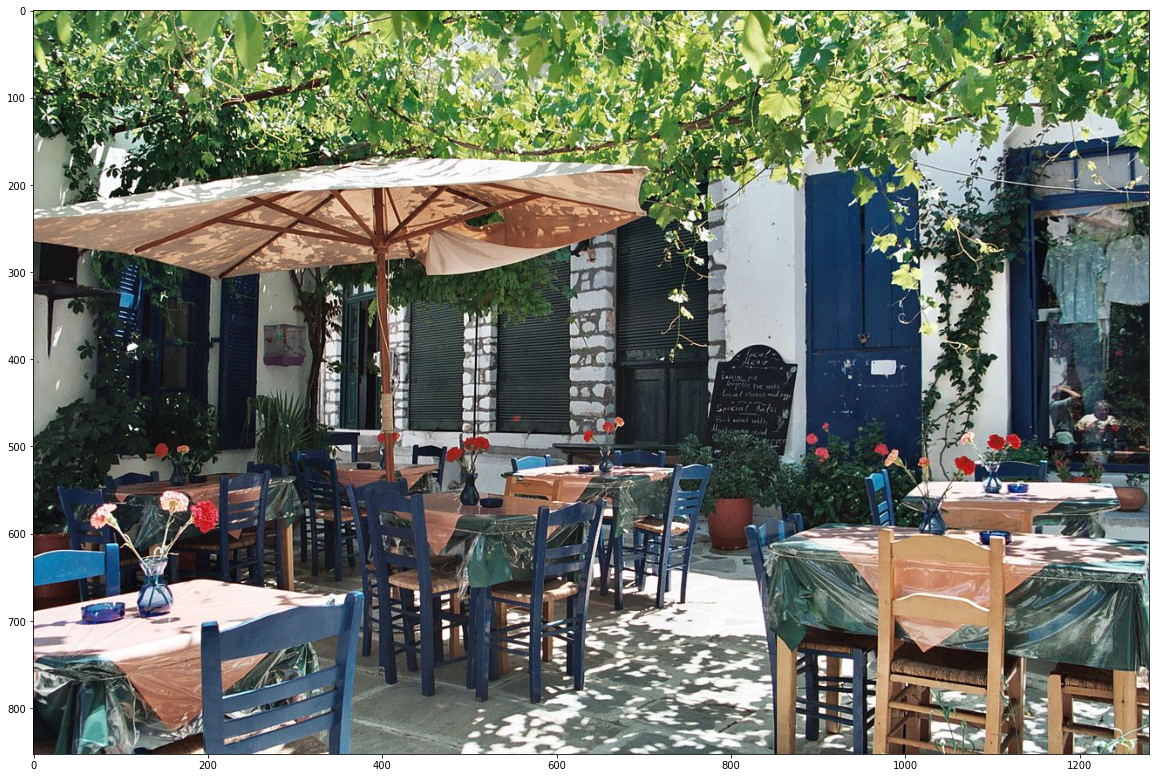

In [16]:
downloaded_image_path = download_and_resize_image(image_urls[0], 1280, 853, True)

Found 100 objects.
Inference time:  21.406994819641113


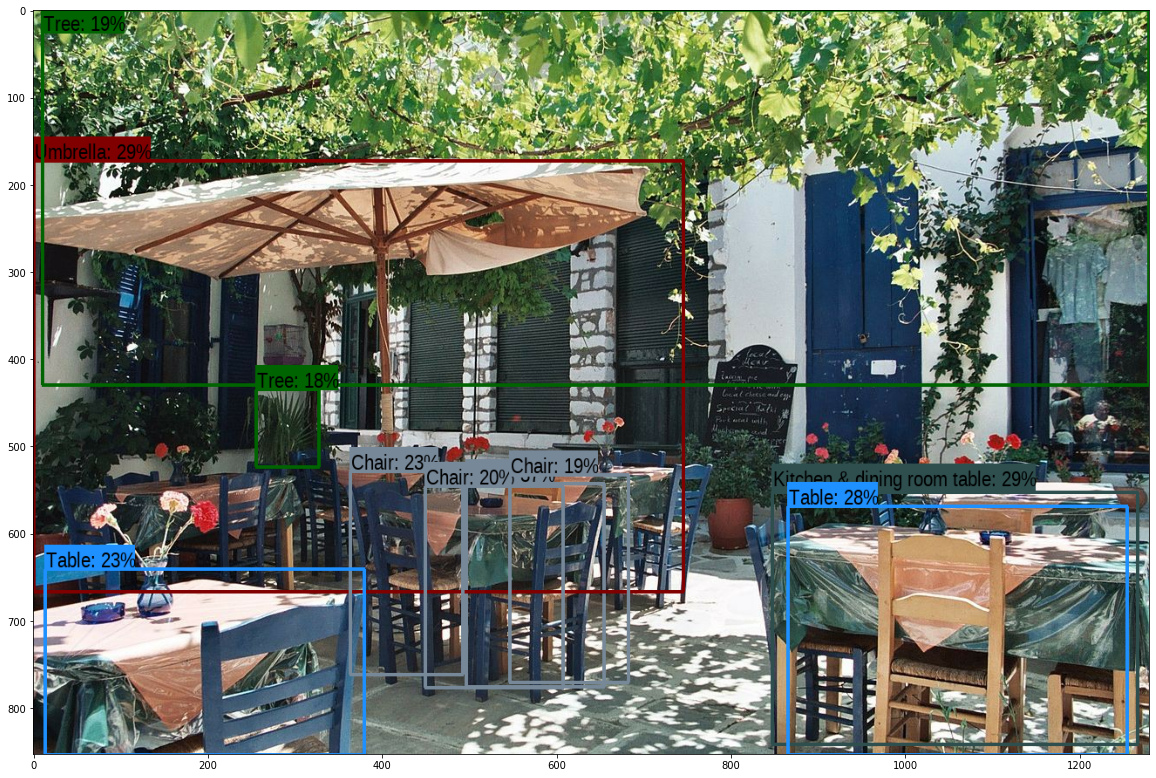

In [17]:
run_detector(detector, downloaded_image_path)

Image downloaded to /tmp/tmpmp20yah_.jpg.
Found 100 objects.
Inference time:  0.12232184410095215
Inference time: 0.8040561676025391


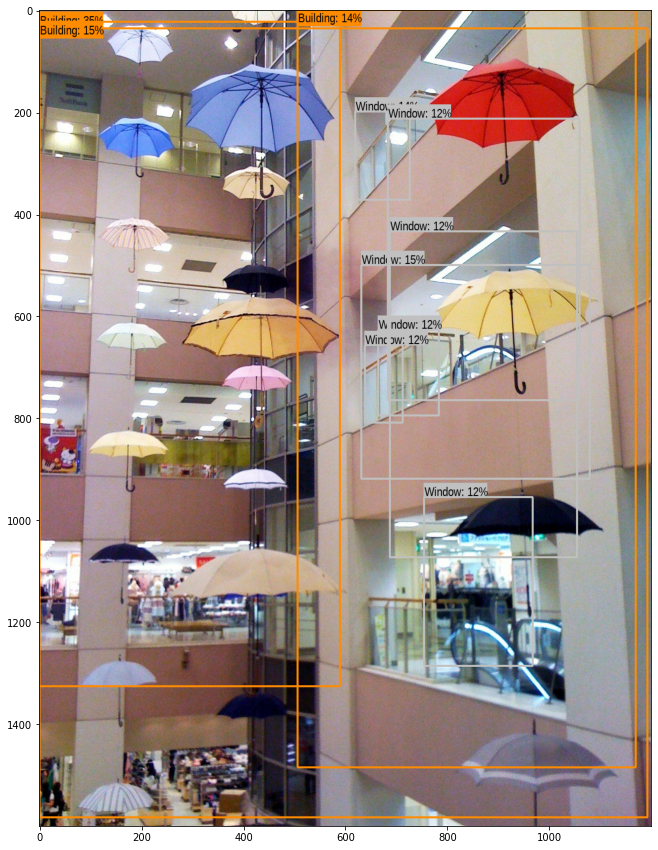

In [18]:
detect_img(image_urls[1], 1200, 1600)

Image downloaded to /tmp/tmpxowfj27s.jpg.
Found 100 objects.
Inference time:  0.15686559677124023
Inference time: 0.42182302474975586


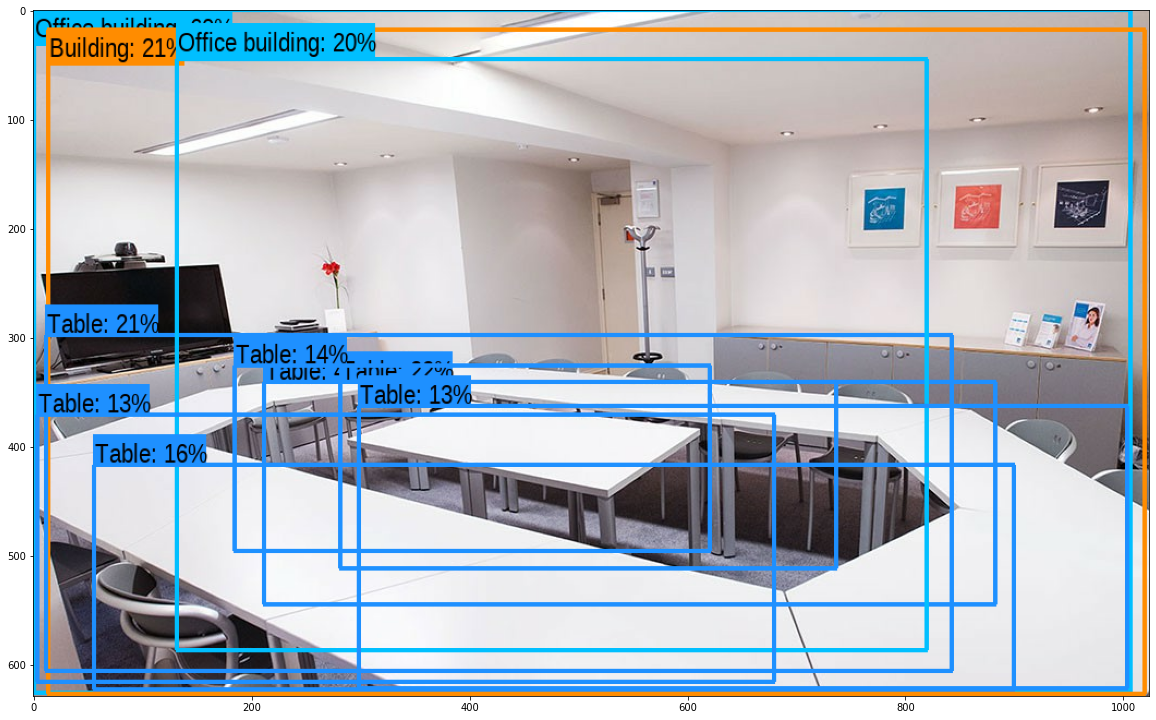

In [19]:
detect_img(image_urls[2], 1024, 629)

Image downloaded to /tmp/tmplys8p29q.jpg.
Found 100 objects.
Inference time:  0.14212322235107422
Inference time: 2.172808885574341


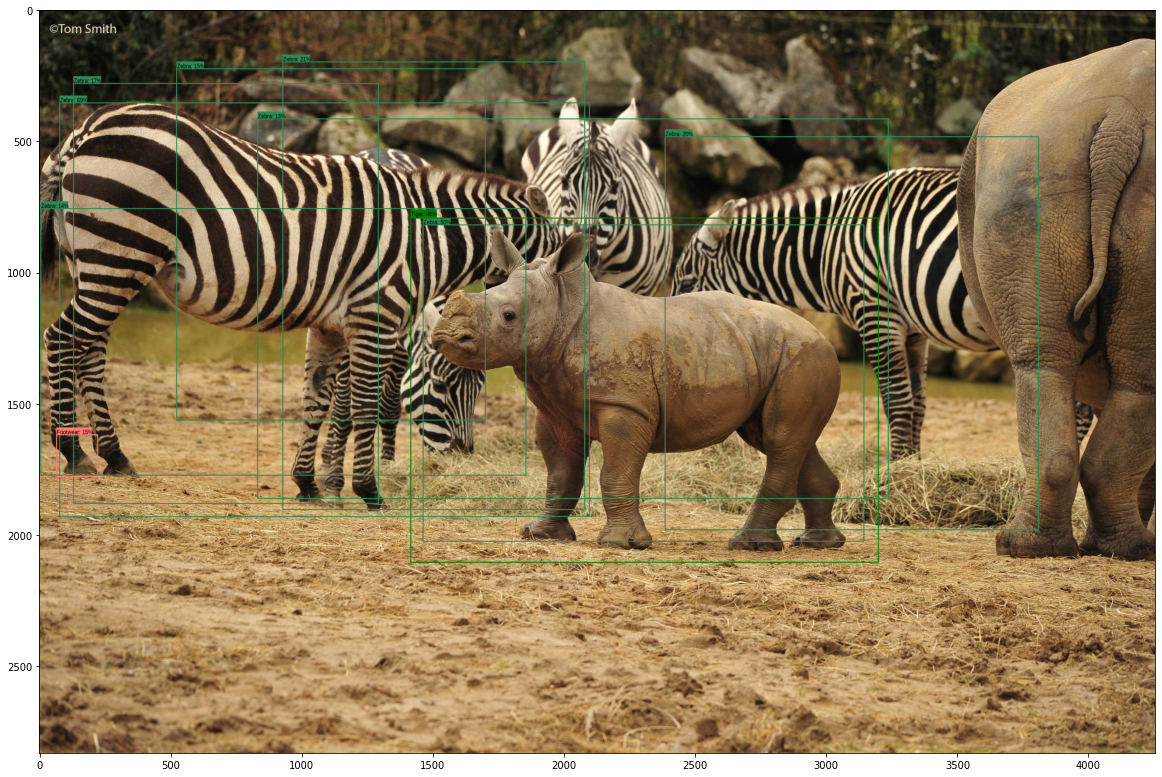

In [20]:
detect_img(image_urls[3], 4256, 2832)

In [21]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 0:00:47.382039
